# Question 1

In this question we will
- Implement the vector grandient operators for colour images.
- Implement the kurtosis measure of image blur/sharpness which is caluclated from image gradients and assess whether it is a reasonable metric of blur.
- Learn to create blur maps of images to visualize the amount of blur in local image patches.



# Step 1: Implement the vector gradient.

Implement the vector gradient as described in the lecture slides in the `color_sobel_edges()` function below.  Use Sobel filters to estimate partial derivatives.  Use the `color_dot_product()` function (provided) to compute the necessary dot products to obtain gxx, gyy, and gxy.  Return an array containing the gradient magnitudes for each pixel, i.e. a graident magnitude image.  Optionally, return a second array containing the gradient directions for each pixel.

The input image must be dtype `float` or `uint8`.  If it is `uint8` convert it to `float` before processing.  Leave the magnitude image ouput as dtype `float` regardless of the input's dtype.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import skimage.filters as filters
import skimage.io as io
import skimage.util as util
%matplotlib inline

In [2]:
def color_dot_product(A, B):
    '''
    Element-by-element dot product in a 2D array of vectors.

    :return: An array in which index [i,j] is the dot product of A[i,j,:] and B[i,j,:].
    '''
    return np.sum(A.conj() * B, axis=2)

In [3]:
def color_sobel_edges(I, get_directions=False):
    # Type Checking
    if I.dtype not in [np.uint8, np.float64]:
        raise ValueError("Input image must be float or uint8")

    # Convert to float
    if I.dtype != np.float64:
        I = util.img_as_float(I)

    # 1. Compute horizontal and vertical partial derivatives of each channel (Use Sobel filters)

    # Horizontal
    u = np.zeros(I.shape)
    for i in range(3):
        u[:, :, i] = filters.sobel_h(I[:, :, i])

    # Vertical
    v = np.zeros(I.shape)
    for i in range(3):
        v[:, :, i] = filters.sobel_v(I[:, :, i])

    # 2. Get gxx, gyy, and gxy using the dot product function
    gxx = color_dot_product(u, u)
    gyy = color_dot_product(v, v)
    gxy = color_dot_product(u, v)

    # 3. Compute gradient magnitude and direction
    directions = 0.5 * np.arctan2(2 * gxy, gxx - gyy)

    magnitude = np.sqrt(
        0.5 * (
                (gxx + gyy)
                + (gxx - gyy) * np.cos(2 * directions)
                + 2 * gxy * np.sin(2 * directions)
        )
    )

    if get_directions:
        return magnitude, directions
    else:
        return magnitude

# Step 2: Examine behavior of the kurtosis sharpness metric.

Write a function which:

* takes as input an input image, a minimum value of sigma, and a maximum value of sigma.
* applies different amounts of Gaussian blur to the original image for integer values of sigma between the provided minimum and maximum values of sigma. (reminder: sigma describes the standard deviation of the gaussian filter mask used to blur the image).
    * Note: if using `skimage.filters.gaussian()`, you'll need to set the `channel_axis` parameter appropriately since you are applying it to a colour image.
* For each blurred image, compute the gradient magnitude using color_sobel_edges(), then compute compute the kurtosis sharpness measure.  This is *log(k+3)* where *k* is the kurtosis of the gradient magnitude image of the blurred image as described in the assignment description document.  See `scipy.stats.kurtosis()`.
* Return a tuple consisting of the range object of sigma values used and the list of computed kurtosis values for each sigma.

Then:
* Call the function using `mushroom.jpg` as the input image, a minimum sigma of 1, and a maximum sigma of 30.  Use a smaller max sigma until you are sure it's working, then increase to 30, as it can take a few minutes to do all the filtering.  Use the return values from your function to plot a line graph of gaussian blur sigma vs. blur measure (kurtosis) for the waterfall image.  Add appropriate axis labels and a descriptive title.  Sample output is provided in the assignment description document.



In [4]:
def test_blur_measure(I, min_sigma, max_sigma):
    # Type Checking
    if I.dtype not in [np.uint8, np.float64]:
        raise ValueError("Input image must be float or uint8")

    # Convert to float
    if I.dtype != np.float64:
        I = util.img_as_float(I)

    # Initialize arrays to store sigma values and corresponding sharpness
    sigmas = range(min_sigma, max_sigma + 1)
    sharpness_values = []

    for sigma in sigmas:
        # Apply Gaussian blur
        blurred = filters.gaussian(I, sigma=sigma, channel_axis=2)

        # Compute gradient magnitude using Sobel edge detection
        magnitude = color_sobel_edges(blurred)

        # Reshape the magnitude array to 1D
        magnitude_1d = magnitude.reshape(-1)

        # Compute the kurtosis
        K = stats.kurtosis(magnitude_1d)

        # Compute the sharpness
        sharpness = np.log(K + 3)

        # Append sharpness value to the list
        sharpness_values.append(sharpness)

    return sigmas, sharpness_values

In [5]:
I = io.imread('data/mushroom.jpg')
sigmas, sharpness_values = test_blur_measure(I, 1, 30)

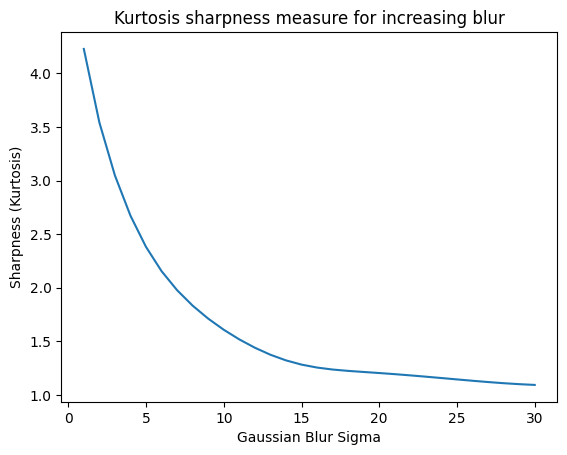

In [6]:
plt.figure()
plt.plot(sigmas, sharpness_values)
plt.xlabel('Gaussian Blur Sigma')
plt.ylabel('Sharpness (Kurtosis)')
plt.title('Kurtosis sharpness measure for increasing blur')
plt.show()

# Step 3:  Create a local blur map

Write a function which:

* takes as input an image and a window size (in pixels).
* computes the local sharpness of the input image (i.e. log(kurtosis+3)) for each tiled, non-overlapping square window of the given window size
* stores each local sharpness in an array where each entry represents one window of the input image (the size of this array can be computed by integer division of the original image dimensions by the window size)
* returns the array of local sharpnesses.

Then:

- call the function you just wrote with `mushroom.jpg` as the input image and 100 as the window size.  
- Plot the returned array as an image using `plt.imshow()`.  Do not rescale this image with `vmin=` or `vmax=`, and use the default colormap (don't change it to `'gray'`).  
- Add a color scale bar using `plt.colorbar()`.  Sample output is provided in the assignment description document.



In [7]:
def sharpness_map(I, window_size):
    if I.dtype not in [np.uint8, np.float64]:
        raise ValueError("Input image must be float or uint8")

    if window_size < 1:
        raise ValueError("Window size must be greater than 0")

    if I.dtype != np.float64:
        I = util.img_as_float(I)

    height, width, _ = I.shape

    n_windows_y = height // window_size
    n_windows_x = width // window_size

    sharpness_array = np.zeros((n_windows_y, n_windows_x))

    for y in range(n_windows_y):
        for x in range(n_windows_x):
            window = I[
                        y * window_size:(y + 1) * window_size,
                        x * window_size:(x + 1) * window_size,
                        :
                     ]
            
            magnitude = color_sobel_edges(window)
            magnitude_1d = magnitude.reshape(-1)
            K = stats.kurtosis(magnitude_1d)
            sharpness = np.log(K + 3)
            sharpness_array[y, x] = sharpness
            
    return sharpness_array

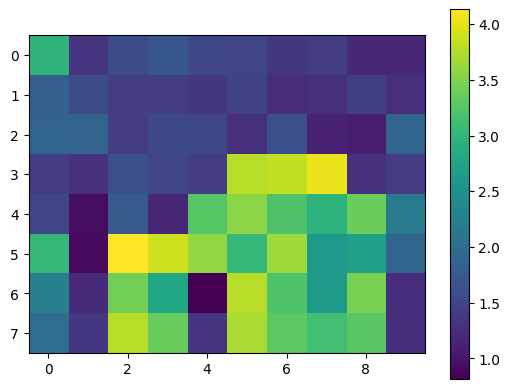

In [8]:
I = io.imread('data/mushroom.jpg')
sharpness_array = sharpness_map(I, 100)
plt.figure()
plt.imshow(sharpness_array)
plt.colorbar()
plt.show()

# Step 4: Try it on another image.

Use the functions you wrote to produce the same plots as in steps 2 and 3 but for the `waterfall.jpg` image instead.


In [9]:
I = io.imread('data/waterfall.jpg')
sigmas, sharpness_values = test_blur_measure(I, 1, 30)

sharpness_array = sharpness_map(I, 100)

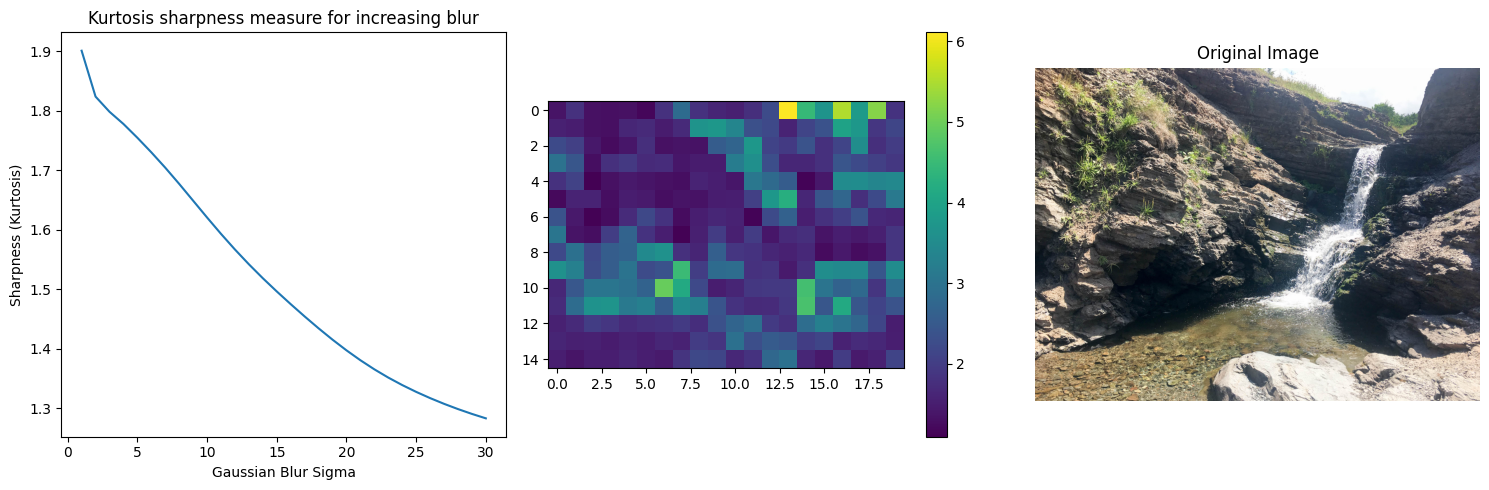

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(sigmas, sharpness_values)
plt.xlabel('Gaussian Blur Sigma')
plt.ylabel('Sharpness (Kurtosis)')
plt.title('Kurtosis sharpness measure for increasing blur')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.imshow(sharpness_array)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(I)
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 5: Thinking and Qualitative Analysis

### Answer the following questions, right here in this block.

1. Based on your observations of the previous results (you can try it on additional images if you wish), discuss the advantages and disadvantages of the kurtosis-based measure of image sharpness, citing specific evidence observed to justify your claims.

    **Advantages:**
   - It's very sensitive to the changes in the image sharpness, so it excels on detecting edges that are blurred. For example, on the `mushroom.jpg` image, you can se how it has a high value when the mushrooms are in focus and a low value when they are blurred on the background.
   - Easy to interpret, low values mean that the image is blurred and high values mean that the image is sharp.

    **Disadvantages:**
    - It dependes on extreme values of the gradient magnitudes, which makes sharpness difficult to measure in regions with low contrast. For example, on the `waterfall.jpg` image, the sharpness map shows a lot of noise in the sky and shadow regions, which are regions with low contrast.
    - It's not as good detecting the blur on regions where there's no sharp edges. For example, on the `waterfall.jpg` image, the sharpness map doesn't display the blur on the water, which is a region with no sharp edges.
    - It is sensitive to noise, so it can find an edge where there is none. For example, on the `waterfall.jpg` image, it happens also in the shadow and sky regions.
    
2. Think of what the shape of a histogram of gradient magnitudes would look like for a sharp image.  Why does this set of gradient magnitudes have high kurtosis?  (It might help to look up kurtosis and see what it measures about a histogram!)

    A histogram of gradient magnitudes in a sharp image would look like it has a lot of magnitude values close to zero and a few values with high magnitudes (since the changes in intensity would be more drastic in sharp images). This set of gradient magnitudes has high kurtosis because it has a lot of values close to the mean and a few values far from the mean, which makes the tails of the histogram longer and the peak higher. Kurtosis measures the tails of the histogram, so high kurtosis means that the tails are longer and the peak is higher.
   

3. Now think what would happen as that same image gets blurrier.  Explain how the shape of the histogram would change, and the corresponding effect on the kurtosis.

	As the image gets blurrier, the histogram will have less extreme values and more values close to the mean, which will make the tails of the histogram shorter and the peak lower. This will make the kurtosis lower, since the tails are shorter and the peak is lower.